In [1]:
#Cryptocurrency to examine: BTC to USD from the bitsamp exchange
from_symbol = 'BTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'hour'

In [2]:
import requests
import pandas as pd
from datetime import datetime
pd.options.mode.chained_assignment = None

#Create Filename for data
def create_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)

#Get the data from cryptocompare.com
def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals
    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data

#Convert to a pandas dataframe
def convert_to_dataframe(data):
    df = pd.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df

data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)

current_datetime = datetime.now().date().isoformat()
filename = create_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Saving data to BTC_USD_Bitstamp_hour_2021-04-18.csv


In [3]:
df.tail()

,datetime,low,high,open,close,volumefrom,volumeto
1996,2021-04-18 10:00:00,54611.49,55529.83,55114.57,54771.50,520.13,28661448.56
1997,2021-04-18 11:00:00,53123.00,55197.77,54771.50,53314.83,444.76,24049805.90
1998,2021-04-18 12:00:00,53314.83,55159.09,53314.83,55058.62,901.70,49183080.34
1999,2021-04-18 13:00:00,54761.56,55436.15,55058.62,55267.33,627.99,34633289.38
2000,2021-04-18 14:00:00,55133.31,55900.00,55267.33,55802.88,193.44,10731302.65


In [4]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
import numpy as np

#creating new dataframe with just the datetime and closing value
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['datetime', 'close'])

for i in range(0,len(data)):
    new_data['datetime'][i] = data['datetime'][i]
    new_data['close'][i] = data['close'][i]

#index the new dataframe with the datetime
new_data.index = new_data.datetime
new_data.drop('datetime', axis=1, inplace=True)

#creating train and test sets, split 80%-20%
dataset = new_data.values
train = dataset[:int(0.8*len(dataset)),:]
valid = dataset[int(0.8*len(dataset)):,:]

#Normalise from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#x_train will be 60 values in the series, y_train will be the 61st value
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape x_train for the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [5]:
#Create the test data with the same setup
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
Y_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
    Y_test.append(inputs[i,0])
X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [19]:
#create and fit the LSTM network
no_of_nodes = 40

model = Sequential()
model.add(LSTM(units=no_of_nodes, return_sequences=False, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
#model.add(LSTM(units=no_of_nodes))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=2)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1540/1540 - 11s - loss: 0.0070 - val_loss: 9.1289e-04
Epoch 2/30
1540/1540 - 9s - loss: 0.0028 - val_loss: 2.9205e-04
Epoch 3/30
1540/1540 - 9s - loss: 0.0020 - val_loss: 3.2419e-04
Epoch 4/30
1540/1540 - 9s - loss: 0.0018 - val_loss: 4.7367e-04
Epoch 5/30
1540/1540 - 9s - loss: 0.0015 - val_loss: 4.7571e-04
Epoch 6/30
1540/1540 - 11s - loss: 0.0013 - val_loss: 5.6034e

In [20]:
prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)
rms=np.sqrt(np.mean(np.power((valid-prediction),2)))
print(rms)

495.0812961151548


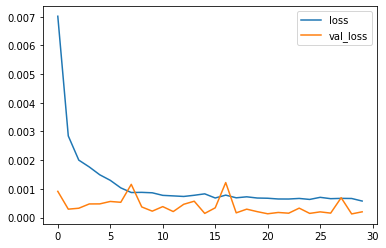

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

<AxesSubplot:xlabel='datetime'>

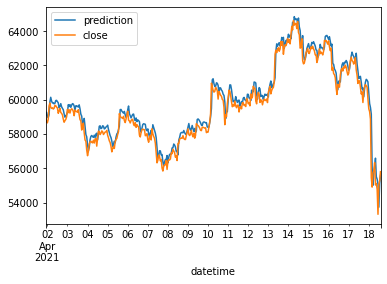

In [22]:
import matplotlib.dates as mdates

valid_df = new_data[int(0.8*len(dataset)):]
valid_df['prediction'] = prediction
valid_df.plot(y=['prediction', 'close'])